# Coverage Rate (Single Parameter) 


This is the Notebook used to analyze whether parameter control impacts the coverage rate.

It is divided into the main sections:

- Prior Predictive Check
- Model specification
- Data analysis

# Prior Predictive Check

Sampling: [a_bar, a_offset, b_offset, g_offset, sigma, sigma_a, sigma_b, sigma_g]


<Figure size 400x300 with 0 Axes>

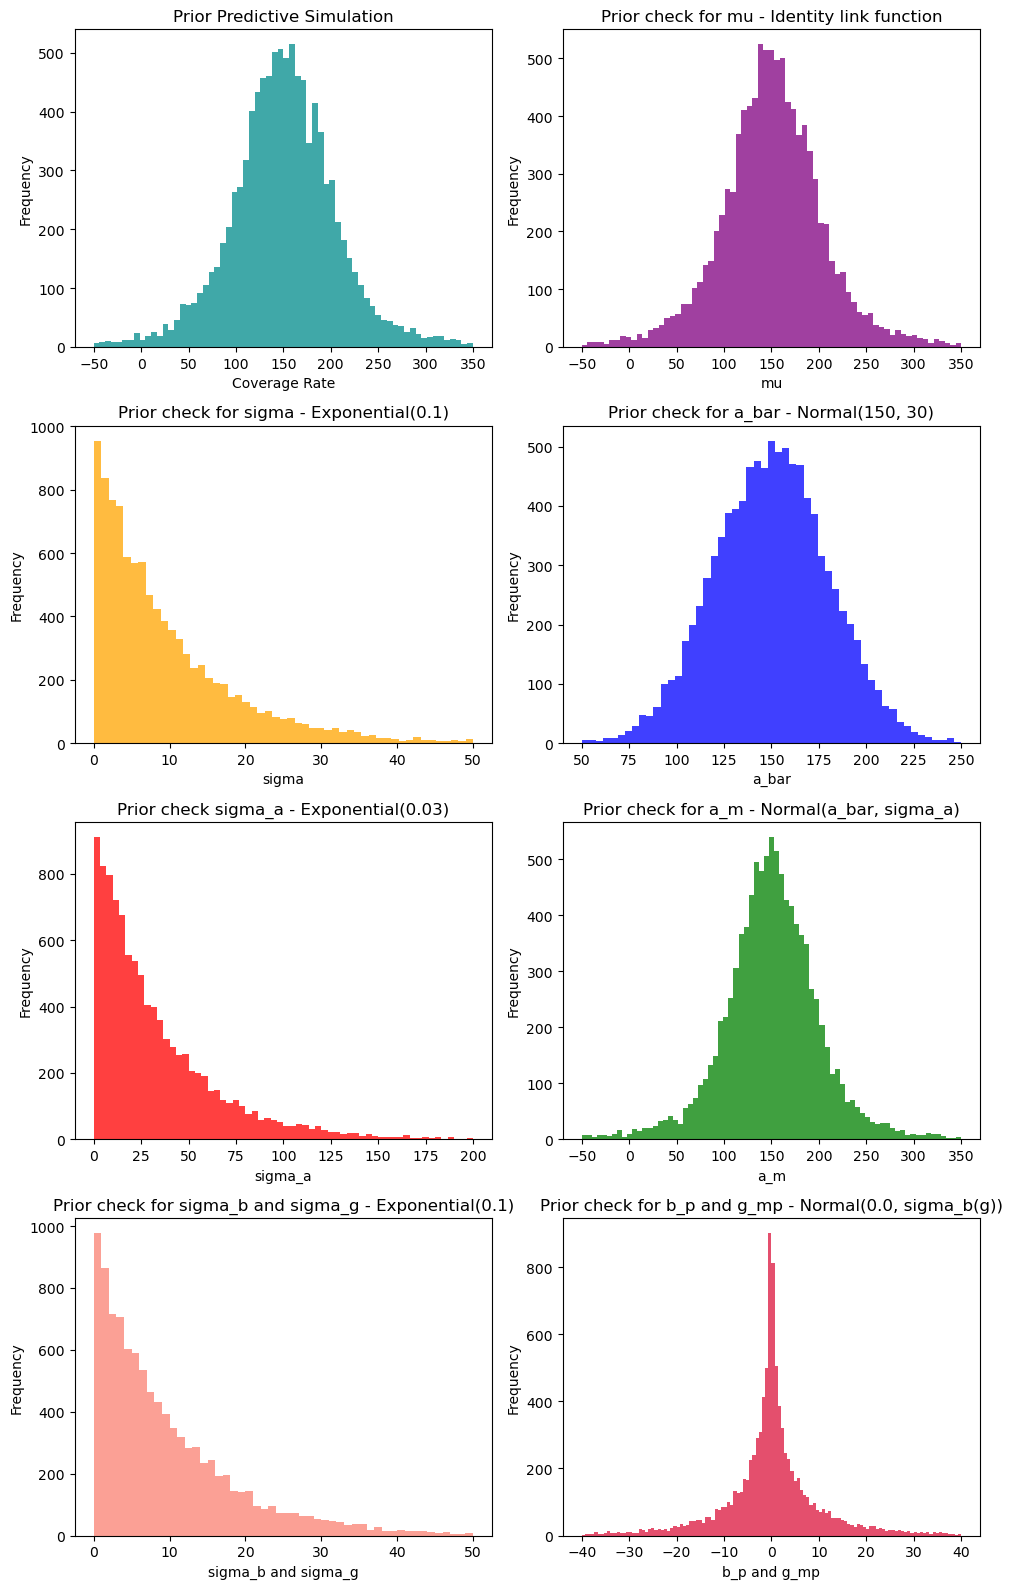

In [13]:
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, FloatSlider
from utils.prior_check_helper import HistogramPlot, plot_histograms

def perform_prior_check(s_a, s_b, s_g, a_bar_mu, a_bar_sigma, e):
    with pm.Model():
        # Global Intercept for modules
        a_bar = pm.Normal('a_bar', mu=a_bar_mu, sigma=a_bar_sigma)
        
        # Standard Deviations for Module, Parameter and Interaction effects
        sigma_a = pm.Exponential('sigma_a', s_a)
        sigma_b = pm.Exponential('sigma_b', s_b)
        sigma_g = pm.Exponential('sigma_g', s_g)
        
        # Modules, Parameters and Interactions effects
        # With non-centered parameterizations (helps with divergences) 
        a_offset = pm.Normal('a_offset', mu=0, sigma=1)
        a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

        b_offset = pm.Normal('b_offset', mu=0, sigma=1)
        b_p = pm.Deterministic('b_p', sigma_b * b_offset)

        g_offset = pm.Normal('g_offset', mu=0, sigma=1)
        g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)


        # Link function (identity), same input as output
        pm.Deterministic('mu_before', a_m + b_p + g_mp)
        pm.Deterministic('mu', a_m + b_p + g_mp)
        
        # Likelihood distribution spread
        pm.Exponential('sigma', e)
        
        # Sample priors from the model
        idata = pm.sample_prior_predictive(samples=10000)



    # Fetch and flatten priors
    prior_mu= idata.prior['mu'].values.flatten()
    prior_sigma = idata.prior['sigma'].values.flatten()

    # Use mu and sigma priors as parameters for a Normal distribution to sample observations
    simulated_observations = np.random.normal(loc=prior_mu, scale=prior_sigma)
    
    # Plot histogram of observations 
    plt.figure(figsize=(4, 3))
    observation_plot = HistogramPlot(simulated_observations,'Prior Predictive Simulation', 'Coverage Rate',
                                     'darkcyan', bin_range=(-50,350))
    #observation_plot.plot()


    # Plot priors for the different parameters
    plots = [
        observation_plot,
        HistogramPlot(idata.prior['mu'].values.flatten(), 'Prior check for mu - Identity link function', 'mu', 'purple', bin_range=(-50, 350)),
        #HistogramPlot(idata.prior['mu_before'].values.flatten(), 'Prior check for "mu" (before link function)', 'mu', 'black', bin_range=(-100, 400)),
        HistogramPlot(idata.prior['sigma'].values.flatten(), 'Prior check for sigma - Exponential(0.1)', 'sigma', 'orange', bin_range=(0,50)),
        HistogramPlot(idata.prior['a_bar'].values.flatten(), 'Prior check for a_bar - Normal(150, 30)', 'a_bar', 'blue', bin_range=(50,250)),
        HistogramPlot(idata.prior['sigma_a'].values.flatten(), 'Prior check sigma_a - Exponential(0.03)', 'sigma_a', 'red', bin_range=(0,200)),
        HistogramPlot(idata.prior['a_m'].values.flatten(), 'Prior check for a_m - Normal(a_bar, sigma_a)', 'a_m', 'green', bin_range=(-50, 350)),
        HistogramPlot(idata.prior['sigma_b'].values.flatten(), 'Prior check for sigma_b and sigma_g - Exponential(0.1)', 'sigma_b and sigma_g', 'salmon', bin_range=(0,50)),
        HistogramPlot(idata.prior['b_p'].values.flatten(), 'Prior check for b_p and g_mp - Normal(0.0, sigma_b(g))', 'b_p and g_mp', 'crimson', bin_range=(-40, 40)),
        #HistogramPlot(idata.prior['sigma_g'].values.flatten(), 'Prior check for "sigma_g" - Exponential(0.1)', 'sigma_g', 'brown',),
        #HistogramPlot(idata.prior['g_mp'].values.flatten(), 'Prior check for "g_mp" - Normal(0.0, sigma_g)', 'g_mp', 'yellow', bin_range=(-100, 100))
    ]

    plot_histograms(plots, 4, 2, figsize=(10,16), save_img=True, prefix_name="coverage_rate_single", output_folder="prior_checks/coverage_rate_single")

perform_prior_check(0.03, 0.1, 0.1, 150 , 30, 0.1)


### UNCOMMENT FOR INTERACTIVE PRIOR CHECK ###

#s_a = FloatSlider(value=0.05, min=0, max=1, step=0.001, description='Sigma_alpha (sigma_a):')
#s_b = FloatSlider(value=0.1, min=0, max=1, step=0.05, description='Sigma_beta (sigma_b):')
#s_g = FloatSlider(value=0.1, min=0, max=1, step=0.05, description='Sigma_gamma (sigma_g):')
#a_bar_mu = FloatSlider(value=150, min=0, max=300, step=0.1, description='alpha bar mu (a_bar_mu):')
#a_bar_sigma = FloatSlider(value=30, min=0, max=300, step=0.1, description='alpha bar sigma (a_bar_sigma):')
#exp_value = FloatSlider(value=0.1, min=0, max=2, step=0.05, description='exponential value (exp_value):')

#interact(perform_prior_check, s_a=s_a, s_b=s_b, s_g=s_g, a_bar_mu=a_bar_mu, a_bar_sigma=a_bar_sigma,e=exp_value)

# Model specification

### Data Preperation

In [22]:
import pandas as pd
import numpy as np
from utils.design_matrix_creator import get_design_matricies

# Load the CSV file
data = pd.read_csv("../single_parameter/combined_data/statistics.csv")

# Select columns for the coverage timeline
coverage_data = data.filter(regex='^CoverageTimeline_T')

# Calculate the integral for each row using the trapezoidal rule
data['IntegralValue'] = coverage_data.apply(lambda row: np.trapz(row, dx=1), axis=1)
            
observation_matrix, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(data, 'IntegralValue')

Module Matrix shape: (9360, 24)
Parameter Matrix shape: (9360, 12)
Interaction Matrix shape: (9360, 288)
Observation Matrix shape: (9360, 1)


### Execute the Model

In [ ]:
import pymc as pm
with pm.Model():
    # Global Intercept for Modules
    a_bar = pm.Normal('a_bar', mu=150, sigma=30)
    
    # Standard deviations for Module, Parameter and Interaction effects
    sigma_a = pm.Exponential('sigma_a', 0.03)
    sigma_b = pm.Exponential('sigma_b', 0.1)
    sigma_g = pm.Exponential('sigma_g', 0.1)
    
    # Non-centered parameterizations for module, parameter and interaction effect.
    a_offset = pm.Normal('a_offset', mu=0, sigma=1, shape=24)
    a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=12)
    b_p = pm.Deterministic('b_p', sigma_b * b_offset)

    g_offset = pm.Normal('g_offset', mu=0, sigma=1, shape=288)
    g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)

    
    # Activate the correct module, parameter and interaction for each run
    identity_a = pm.math.dot(module_matrix, a_m)
    identity_b = pm.math.dot(parameter_matrix, b_p)
    identity_g = pm.math.dot(interaction_matrix, g_mp)

    # Link function (identity), same input as output
    mu = pm.Deterministic('mu', identity_a + identity_b + identity_g)
    
    # Normal distribution likelihood with parameter mu and sigma
    sigma = pm.Exponential('sigma', 0.1) # standard deviation
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=observation_matrix['IntegralValue'])
    
    # Sample from the model
    trace = pm.sample(5000, chains=4, return_inferencedata=True, progressbar=True, target_accept=0.95)
    log_lik = pm.compute_log_likelihood(trace)

### Save the results

In [ ]:
import arviz as az

az.to_netcdf(trace, "coverage_rate_model_single_parameter.nc")

# Data analysis

### Generate summary object

In [2]:
import arviz as az
from utils.inference_data_helper import create_inference_data_from_trace, log_to_exp


# Example usage
trace = az.from_netcdf("coverage_rate_model_single_parameter.nc")
variable_list = ['a_m', 'a_bar', 'sigma_a', 'sigma', 'sigma_b', 'b_p', 'sigma_g', 'g_mp']
transformations = {}

idata = create_inference_data_from_trace(trace, variable_list, transformations)
summary = az.summary(idata, variable_list, hdi_prob=0.89)
summary

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_m[0],258.799,0.838,257.478,260.155,0.006,0.004,21055.0,17899.0,1.0
a_m[1],199.349,0.839,198.014,200.699,0.006,0.004,20340.0,16014.0,1.0
a_m[2],276.089,0.843,274.778,277.469,0.006,0.004,21195.0,17427.0,1.0
a_m[3],13.796,0.844,12.472,15.160,0.006,0.004,20388.0,17521.0,1.0
a_m[4],19.959,0.842,18.710,21.412,0.006,0.004,20955.0,17639.0,1.0
...,...,...,...,...,...,...,...,...,...
g_mp[283],-0.399,1.531,-2.789,2.101,0.009,0.011,30818.0,15846.0,1.0
g_mp[284],-0.507,1.498,-2.880,1.909,0.008,0.011,35401.0,15256.0,1.0
g_mp[285],-0.050,1.518,-2.410,2.459,0.009,0.012,31476.0,14213.0,1.0
g_mp[286],-0.017,1.530,-2.416,2.431,0.008,0.012,34404.0,15124.0,1.0


### Replace numeric identifiers with descriptive identifiers

In [4]:
from utils.summary_table_formatting import update_table, get_replacement_list
from utils.design_matrix_creator import get_design_matricies
import pandas as pd


_, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(pd.read_csv("../single_parameter/combined_data/statistics.csv"), 'AlgorithmIterations')

module_names = get_replacement_list(module_matrix.columns)
parameter_names = get_replacement_list(parameter_matrix.columns)
interaction_names = get_replacement_list(interaction_matrix.columns)

update_table(summary, 'a_m', replacement=module_names)
update_table(summary, 'b_p', replacement=parameter_names)
update_table(summary, 'g_mp', replacement=interaction_names)

summary.sort_values(by='mean', ascending=True)

Module Matrix shape: (9360, 24)
Parameter Matrix shape: (9360, 12)
Interaction Matrix shape: (9360, 288)
Observation Matrix shape: (9360, 1)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
g_mp[return_from_generator x Pop],-7.822,1.924,-10.820,-4.694,0.016,0.011,14749.0,13306.0,1.0
g_mp[return_from_generator x ChromLen],-6.045,1.787,-8.970,-3.248,0.014,0.010,16888.0,14842.0,1.0
g_mp[return_from_generator x Crossover],-5.790,1.753,-8.483,-2.885,0.013,0.009,19290.0,15460.0,1.0
g_mp[return_from_generator x TestDeleteProb],-4.562,1.680,-7.116,-1.758,0.012,0.009,18784.0,14865.0,1.0
g_mp[yield_from x ChangeParamProb],-2.833,1.591,-5.433,-0.345,0.009,0.008,29591.0,14180.0,1.0
...,...,...,...,...,...,...,...,...,...
a_m[da],239.218,0.834,237.902,240.556,0.006,0.004,20936.0,17194.0,1.0
a_m[timer],258.799,0.838,257.478,260.155,0.006,0.004,21055.0,17899.0,1.0
a_m[validation],273.575,0.845,272.249,274.939,0.006,0.004,20913.0,17809.0,1.0
a_m[maybe],273.985,0.848,272.667,275.373,0.006,0.004,19696.0,17023.0,1.0


### Plot the prior distributions and their assosicated trace plots

array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>],
       [<Axes: title={'center': 'g_mp'}>,
        <Axes: title={'center': 'g_mp'}>],
       [<Axes: title={'center': 'a_bar'}>,
        <Axes: title={'center': 'a_bar'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>],
       [<Axes: title={'center': 'sigma_g'}>,
        <Axes: title={'center': 'sigma_g'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

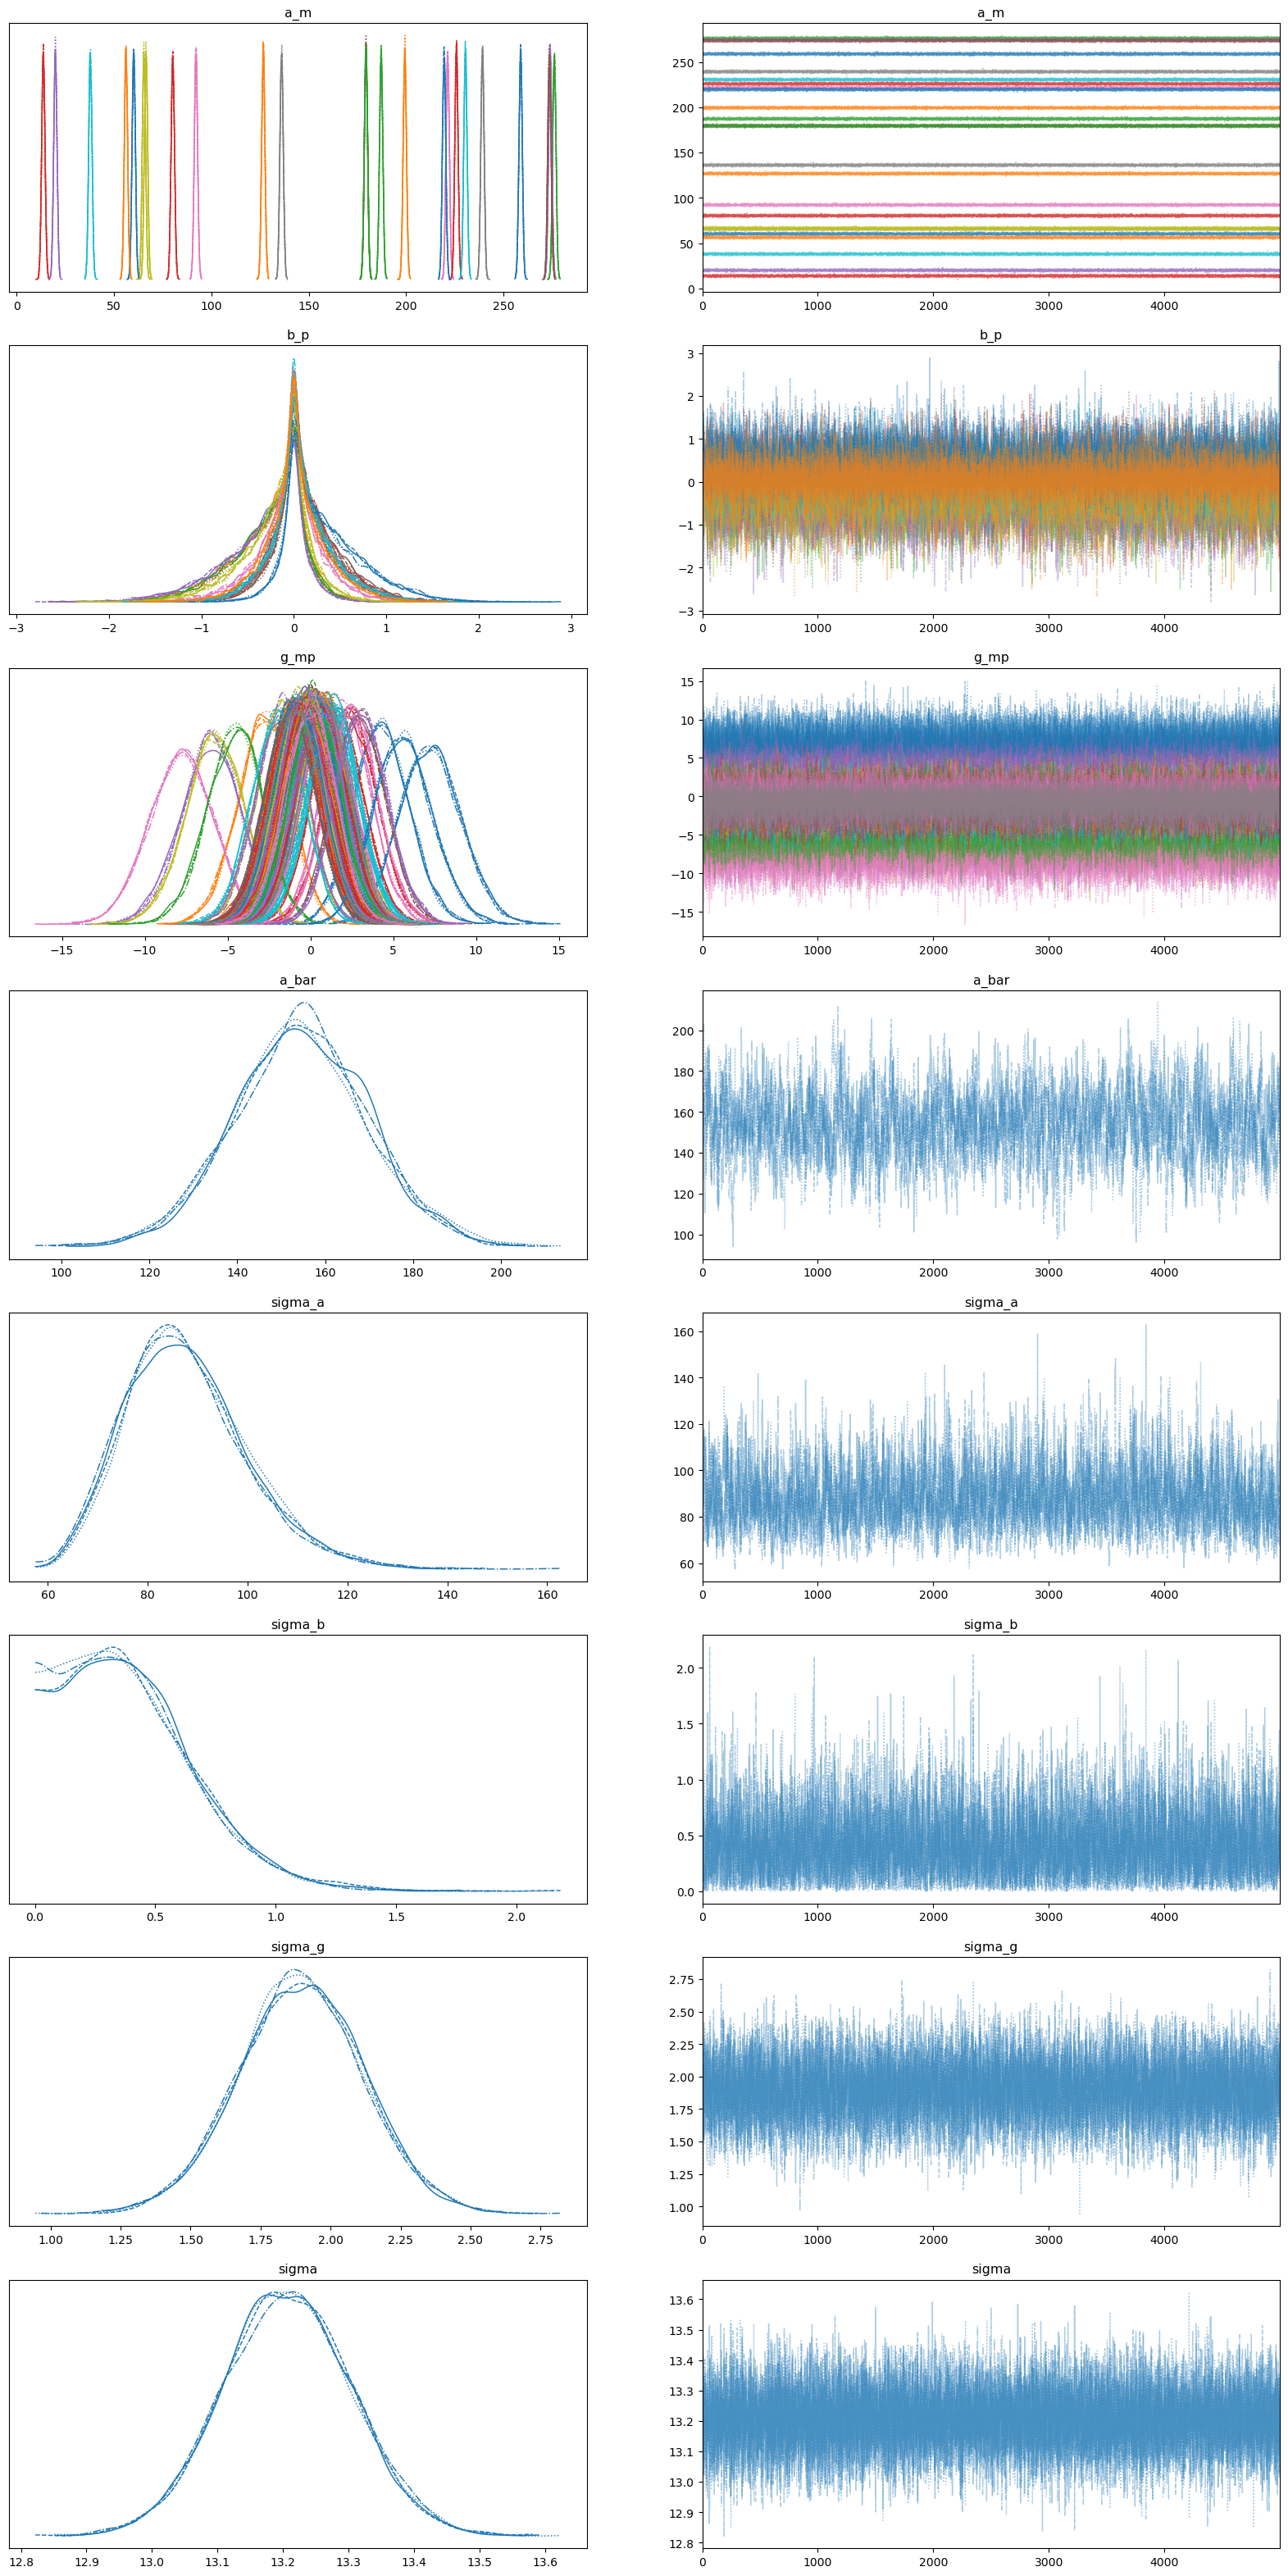

In [5]:
az.plot_trace(idata, var_names=['a_m', 'b_p', 'g_mp', 'a_bar', 'sigma_a', 'sigma_b', 'sigma_g', 'sigma'], figsize=(20, 40))